Problem Statement - Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.tsa.api as tsa
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [2]:
df = pd.read_excel('Airlines+Data.xlsx')

In [3]:
df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


### Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [5]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

<AxesSubplot:xlabel='Month', ylabel='Passengers'>

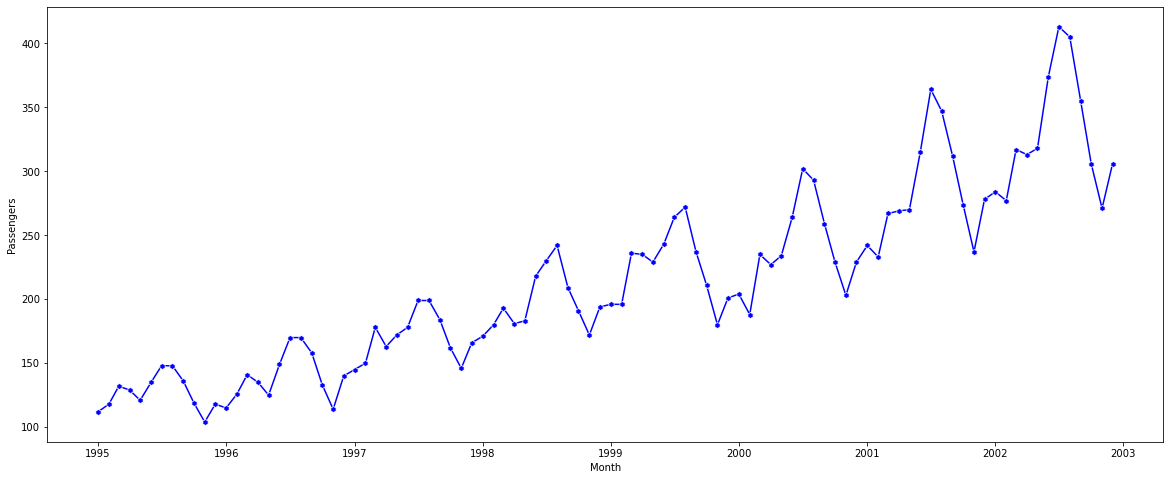

In [6]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(x = "Month",y = "Passengers", data = df, color = "Blue", marker = "h")

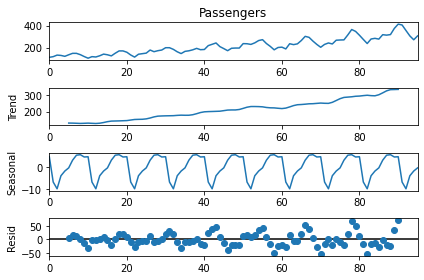

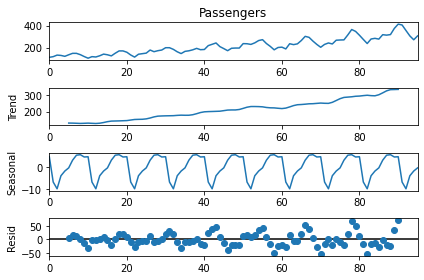

In [8]:
seasonal_ts_add= tsa.seasonal_decompose(df["Passengers"], period=10)
seasonal_ts_add.plot()

In [9]:
df['Month'] = pd.to_datetime(df['Month'])
df['Months'] = df['Month'].dt.strftime('%b')
df.head()

,Month,Passengers,Months
0,1995-01-01,112,Jan
1,1995-02-01,118,Feb
2,1995-03-01,132,Mar
3,1995-04-01,129,Apr
4,1995-05-01,121,May


<AxesSubplot:>

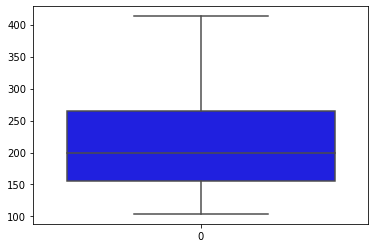

In [10]:
sns.boxplot(data=df['Passengers'],color='blue')

In [11]:
month_dummies = pd.DataFrame(pd.get_dummies(df['Months']))
df1 = pd.concat([df,month_dummies],axis = 1)
df1.head()

,Month,Passengers,Months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,0,0,0,0,0,0,0,0,1,0,0,0


In [12]:
df1["t"] = np.arange(1,97)
df1["t_squared"] = df1["t"]*df1["t"]
df1["log_Passengers"] = np.log(df1["Passengers"])
df1.columns
df1.head()

,Month,Passengers,Months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_squared,log_Passengers
0,1995-01-01,112,Jan,0,0,0,0,1,0,0,0,0,0,0,0,1,1,4.718499
1,1995-02-01,118,Feb,0,0,0,1,0,0,0,0,0,0,0,0,2,4,4.770685
2,1995-03-01,132,Mar,0,0,0,0,0,0,0,1,0,0,0,0,3,9,4.882802
3,1995-04-01,129,Apr,1,0,0,0,0,0,0,0,0,0,0,0,4,16,4.859812
4,1995-05-01,121,May,0,0,0,0,0,0,0,0,1,0,0,0,5,25,4.795791


In [13]:
# Segreate the Train & Test Data

train=df1.head(75)
test=df1.tail(25)

# Linear Model

In [14]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))                 # Predict on test data
rmse_linear = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_linear))**2)) # Calculate RMSE --> test -predict_linear
print("RMSE Linear: ",rmse_linear)

RMSE Linear:  51.83809749584509


# Exponential Model

In [15]:
Exp = smf.ols('log_Passengers~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
print("RMSE Exponential: ",rmse_Exp)

RMSE Exponential:  42.77525975019796


# Quadratic Model

In [16]:
Quad = smf.ols('Passengers~t+t_squared',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_Quad))**2))
print("RMSE Quadratic: ",rmse_Quad)

RMSE Quadratic:  54.031406456252654


# Additive Seasonality Model

In [17]:
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_add_sea)

RMSE Additive seasonality:  123.02763788084238


# Additive Seasonality Quadratic Model

In [18]:
add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_add_sea_quad))**2))
print("RMSE Additive Seasonality Quadratic:",rmse_add_sea_quad )

RMSE Additive Seasonality Quadratic: 36.5362744454732


# Multiplicative Seasonality Model

In [19]:
Mul_sea = smf.ols('log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
print("RMSE Multiplicative Seasonality:",rmse_Mult_sea)

RMSE Multiplicative Seasonality: 128.16622817596155


# Multiplicative Additive Seasonality Model

In [20]:
Mul_Add_sea = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print("RMSE Multiplicative Additive Seasonality:",rmse_Mult_add_sea )

RMSE Multiplicative Additive Seasonality: 11.565825437686447


In [21]:
data1 = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data1)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,51.838097
1,rmse_Exp,42.775260
2,rmse_Quad,54.031406
3,rmse_add_sea,123.027638
4,rmse_add_sea_quad,36.536274
5,rmse_Mult_sea,128.166228
6,rmse_Mult_add_sea,11.565825


In [22]:
data = [['2003-01-01', 'Jan'], ['2003-02-01', 'Feb'], ['2003-03-01', 'Mar'],['2003-04-01', 'Apr'],['2003-5-01', 'May'],['2003-06-01', 'Jun'],
        ['2003-07-01', 'Jul'],['2003-08-01', 'Aug'],['2003-09-01', 'Sep'],['2003-10-01', 'Oct'],['2003-11-01', 'Nov'],['2003-12-01', 'Dec']]
forecast = pd.DataFrame(data, columns = ['Date', 'Months'])
forecast

,Date,Months
0,2003-01-01,Jan
1,2003-02-01,Feb
2,2003-03-01,Mar
3,2003-04-01,Apr
4,2003-5-01,May
5,2003-06-01,Jun
6,2003-07-01,Jul
7,2003-08-01,Aug
8,2003-09-01,Sep
9,2003-10-01,Oct


In [23]:
# Create dummies & T and T-Squared columns

dummies = pd.DataFrame(pd.get_dummies(forecast['Months']))
forecast1 = pd.concat([forecast,dummies],axis = 1)

forecast1["t"] = np.arange(1,13)   
forecast1["t_squared"] = forecast1["t"]*forecast1["t"] 
print("\nDummy, T and T-Square\n\n",forecast1.head())


Dummy, T and T-Square

          Date Months  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  May  Nov  Oct  \
0  2003-01-01    Jan    0    0    0    0    1    0    0    0    0    0    0   
1  2003-02-01    Feb    0    0    0    1    0    0    0    0    0    0    0   
2  2003-03-01    Mar    0    0    0    0    0    0    0    1    0    0    0   
3  2003-04-01    Apr    1    0    0    0    0    0    0    0    0    0    0   
4   2003-5-01    May    0    0    0    0    0    0    0    0    1    0    0   

   Sep  t  t_squared  
0    0  1          1  
1    0  2          4  
2    0  3          9  
3    0  4         16  
4    0  5         25  


In [24]:
# Forecasting using Multiplicative Additive Seasonality Model Because RMSE Value is Less Compared to  Other RMSE Values

model_full = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data =df1).fit()
pred_new  = pd.Series(model_full.predict(forecast1))

forecast1["Forecasted_log"] = pd.Series(pred_new)

forecast1['Forecasted_Passengers'] = np.exp(forecast1['Forecasted_log'])

In [25]:
# Final Prediction for next 12 months

Final_predict = forecast1.loc[:, ['Date', 'Forecasted_Passengers']] 
Final_predict

,Date,Forecasted_Passengers
0,2003-01-01,109.176148
1,2003-02-01,110.331245
2,2003-03-01,127.315234
3,2003-04-01,123.200587
4,2003-5-01,122.399578
5,2003-06-01,138.536397
6,2003-07-01,154.066959
7,2003-08-01,153.741209
8,2003-09-01,137.693733
9,2003-10-01,120.894736


### CONCLUSION 

 The following model is being able to predict the values  